In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# from sklearn.feature_selection import r_regression
# from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
# load utilities

%run ./utility/utilities.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.2
ipykernel        : 6.29.5
ipywidgets       : 8.1.3
jupyter_client   : 8.6.2
jupyter_core     : 5.7.2
jupyter_server   : 2.7.0
jupyterlab       : 4.2.3
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.1
qtconsole        : 5.5.2
traitlets        : 5.14.3


## Training and Testing dataset (7 robust predictive features) 

In [4]:
# (B001 - B131) 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
data = pd.read_excel('data/BladderCancer_132P_TIL_prd1.xlsx')
data = data.loc[0:130]

Ndata = data[['ID','Surgeon','Age_at_Surgery','Race','Surgery','Smoker','BMI',\
              'NAC','cT','pT','cT_or_pT','pN','Bx_Histology','Histology',\
              'Sample_weight_g_tumor','Tumor_digest_count_primary_tumor','Number_of_fragments_plated_tumor',\
              'Overall_TIL_growth']].copy()

Ndata = Ndata.replace(to_replace="Yes",value="Yes TIL")
Ndata = Ndata.replace(to_replace="No",value="No TIL")

Ndata = Ndata.replace(r'^\s*$', np.nan, regex=True) # Replace Blank values with DataFrame.replace() methods.

Extracted_col0 = Ndata.iloc[:,0:1]  # "ID"
Extracted_col1 = Ndata['Surgeon']
Extracted_col2 = Ndata['Age_at_Surgery']
Extracted_col3 = Ndata['BMI']
Extracted_col4 = Ndata['cT_or_pT']
# Extracted_col5 = Ndata['Histology'] # may remove
Extracted_col6 = Ndata['Sample_weight_g_tumor']
Extracted_col7 = Ndata['Tumor_digest_count_primary_tumor']
Extracted_col8 = Ndata['Number_of_fragments_plated_tumor']
Extracted_col9 = Ndata['Overall_TIL_growth']

ndata_sel = Extracted_col0
ndata_sel = ndata_sel.join(Extracted_col1)
ndata_sel = ndata_sel.join(Extracted_col2)
ndata_sel = ndata_sel.join(Extracted_col3)
ndata_sel = ndata_sel.join(Extracted_col4)
# ndata_sel = ndata_sel.join(Extracted_col5) # may remove
ndata_sel = ndata_sel.join(Extracted_col6)
ndata_sel = ndata_sel.join(Extracted_col7)
ndata_sel = ndata_sel.join(Extracted_col8)
ndata_sel = ndata_sel.join(Extracted_col9)

ndata_sel = ndata_sel.rename(columns={'Overall_TIL_growth': 'OverallTILGrowth'})

Cols = ['Surgeon','Age at Surgery','BMI',\
        'cT or pT',\
        'Sample weight (g) tumor','Tumor digest count (primary tumor)','Number of fragments plated (tumor)',\
        'OverallTILGrowth']

feats = ['Surgeon','Age at Surgery','Race','Surgery','Smoker','BMI',\
        'NAC','cT','pT','cT or pT','pN','Bx Histology','Histology',\
        'Sample weight (g) tumor','Tumor digest count (primary tumor)','Number of fragments plated (tumor)']

feat_labels = feats

In [5]:
# Filter all rows for which has NaN (7 Robust & Predictive Features)

ndata_sel.dropna(inplace=True) # drop rows with Nan, no entries
# ndata_filt = ndata_sel[ndata_sel['OverallTILGrowth'].notna()]


ndata_filt = ndata_sel
print(ndata_filt.shape)

(102, 9)


In [6]:
ndata_filt = ndata_filt.replace(to_replace='Yes TIL',value='1')
ndata_filt = ndata_filt.replace(to_replace='No TIL',value='-1')

# convert column "OverallTILGrowth" of Ndata to numerics
ndata_filt["OverallTILGrowth"] = pd.to_numeric(ndata_filt["OverallTILGrowth"])

ndata_filt.head()

,ID,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
0,B001,4.0,68.0,21.05,4.0,1.66,60000000.0,24.0,-1
1,B002,4.0,57.0,33.76,4.0,0.46,5000000.0,12.0,1
2,B003,1.0,61.0,26.28,7.0,1.17,3500000.0,12.0,1
3,B004,1.0,91.0,19.22,4.0,0.71,1300000.0,12.0,1
7,B008,2.0,79.0,26.71,4.0,0.04,300000.0,5.0,1


In [7]:
print(ndata_filt.shape)

(102, 9)


## remove the Ext validation data from the dataset

In [8]:
n_X_ExtVal_ID = ['B035', 'B023', 'B089', 'B102', 'B091', 'B093', 'B002', 'B008', 'B004', 'B015', 'B020', 'B014', 'B099', 'B083', 'B012', 'B028', 'B021', 'B052', 'B054', 'B027']

# 
n_X_ExtVal = ndata_filt[ndata_filt['ID'].isin(n_X_ExtVal_ID)]

In [9]:
n_X_ExtVal.head()

,ID,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
1,B002,4.0,57.0,33.76,4.0,0.46,5000000.0,12.0,1
3,B004,1.0,91.0,19.22,4.0,0.71,1300000.0,12.0,1
7,B008,2.0,79.0,26.71,4.0,0.04,300000.0,5.0,1
11,B012,2.0,78.0,26.33,1.0,0.17,600000.0,5.0,-1
13,B014,4.0,69.0,34.21,4.0,1.30,2800000.0,6.0,1


In [10]:
y_ExtVal = n_X_ExtVal.iloc[:, -1] #.values

In [11]:
def remove_ExtVal_from_df(df1,df2):
    values_to_remove = list(df1['ID'].values)
    n_set = len(values_to_remove)
    
    for i in range(n_set):
        tmp = df2[df2['ID'] == values_to_remove[i]].index
        df2.drop(tmp,inplace=True)

    return df2

In [12]:
# 

Xy_filt = remove_ExtVal_from_df(n_X_ExtVal,ndata_filt)

print(Xy_filt.shape)

(82, 9)


In [13]:
# 

Xy_filt = Xy_filt.drop('ID', axis=1)
Xy_filt = Xy_filt.apply(pd.to_numeric) # convert all columns of Ndata to numerics

X = Xy_filt.iloc[:,:-1]
y = Xy_filt.iloc[:, -1] #.values

X.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor
0,4.0,68.0,21.05,4.0,1.66,60000000.0,24.0
2,1.0,61.0,26.28,7.0,1.17,3500000.0,12.0
8,1.0,71.0,20.19,4.0,0.00,210000.0,12.0
10,4.0,73.0,33.95,4.0,0.00,2000000.0,10.0
12,4.0,68.0,21.32,7.0,0.34,465000.0,6.0


In [14]:
print(X.shape)

(82, 7)


In [15]:
print(y.shape)

(82,)


In [16]:
# data (B001 - B131)

X_train, X_test, y_train, y_test = data_split(X,y,rnd_st=1234,tst_sz=0.30)        # working best for now


In [17]:
X_train.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor
43,4.0,57.0,36.75,3.0,1.20,5300000.0,16.0
49,6.0,52.0,20.84,11.0,5.06,33600000.0,24.0
94,4.0,73.0,29.00,3.0,0.45,450000.0,18.0
107,1.0,77.0,26.17,1.0,0.67,64000.0,24.0
65,7.0,72.0,32.73,5.0,1.00,1000000.0,6.0


In [18]:
X_test.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor
125,5.0,54.0,33.58,1.0,0.548,0.0,12.0
127,4.0,81.0,28.74,1.0,0.000,0.0,1.0
115,4.0,79.0,28.86,3.0,0.050,217000.0,2.0
114,2.0,61.0,30.21,2.0,0.340,150000.0,6.0
12,4.0,68.0,21.32,7.0,0.340,465000.0,6.0


In [19]:
scaler = StandardScaler().fit(X_train) # build a scaler for the training data


In [20]:
# scaled x_train

X_train_sc = scaler.transform(X_train) # use the scaler to transform the training data

In [21]:
# scaled x_test

X_test_sc = scaler.transform(X_test) # use the scaler to transform the testing data


## Testing on the Ext Validation set

In [22]:

n_X_ExtVal_r = n_X_ExtVal[['Surgeon','Age_at_Surgery','BMI','cT_or_pT','Sample_weight_g_tumor',\
                          'Tumor_digest_count_primary_tumor','Number_of_fragments_plated_tumor']].copy()


n_X_ExtVal_r = n_X_ExtVal_r.apply(pd.to_numeric) # convert all columns of Ndata to numerics

# scaled x_ExtVal
X_extVal_sc = scaler.transform(n_X_ExtVal_r)

In [23]:
# Boxplot for training data, testing data, ext validation data


bx_trn = pd.concat([X_train,y_train], axis=1)
bx_tst = pd.concat([X_test,y_test], axis=1)
bx_ext = pd.concat([n_X_ExtVal_r,y_ExtVal], axis=1)

bx_trn['OverallTILGrowth'] = bx_trn['OverallTILGrowth'].replace(to_replace=1,value="Yes TIL")
bx_trn['OverallTILGrowth'] = bx_trn['OverallTILGrowth'].replace(to_replace=-1,value="No TIL")

bx_tst['OverallTILGrowth'] = bx_tst['OverallTILGrowth'].replace(to_replace=1,value="Yes TIL")
bx_tst['OverallTILGrowth'] = bx_tst['OverallTILGrowth'].replace(to_replace=-1,value="No TIL")

bx_ext['OverallTILGrowth'] = bx_ext['OverallTILGrowth'].replace(to_replace=1,value="Yes TIL")
bx_ext['OverallTILGrowth'] = bx_ext['OverallTILGrowth'].replace(to_replace=-1,value="No TIL")


# print(bx_trn)
# print(bx_tst)
# print(bx_ext)

In [24]:
print(bx_trn.shape)
print(bx_tst.shape)
print(bx_ext.shape)

(57, 8)
(25, 8)
(20, 8)


In [25]:
bx_trn.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
43,4.0,57.0,36.75,3.0,1.20,5300000.0,16.0,No TIL
49,6.0,52.0,20.84,11.0,5.06,33600000.0,24.0,Yes TIL
94,4.0,73.0,29.00,3.0,0.45,450000.0,18.0,Yes TIL
107,1.0,77.0,26.17,1.0,0.67,64000.0,24.0,No TIL
65,7.0,72.0,32.73,5.0,1.00,1000000.0,6.0,No TIL


In [26]:
bx_trn

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
43,4.0,57.0,36.75,3.0,1.200,5300000.0,16.0,No TIL
49,6.0,52.0,20.84,11.0,5.060,33600000.0,24.0,Yes TIL
94,4.0,73.0,29.00,3.0,0.450,450000.0,18.0,Yes TIL
107,1.0,77.0,26.17,1.0,0.670,64000.0,24.0,No TIL
65,7.0,72.0,32.73,5.0,1.000,1000000.0,6.0,No TIL
130,2.0,47.0,22.52,1.0,0.012,0.0,2.0,Yes TIL
93,2.0,60.0,4.89,3.0,0.000,0.0,0.0,No TIL
52,4.0,75.0,28.35,8.0,0.000,1000000.0,12.0,Yes TIL
89,5.0,57.0,47.14,6.0,1.000,23600000.0,18.0,Yes TIL
61,5.0,79.0,39.58,11.0,2.340,1750000.0,24.0,Yes TIL


In [27]:
bx_tst.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
125,5.0,54.0,33.58,1.0,0.548,0.0,12.0,Yes TIL
127,4.0,81.0,28.74,1.0,0.000,0.0,1.0,No TIL
115,4.0,79.0,28.86,3.0,0.050,217000.0,2.0,Yes TIL
114,2.0,61.0,30.21,2.0,0.340,150000.0,6.0,Yes TIL
12,4.0,68.0,21.32,7.0,0.340,465000.0,6.0,Yes TIL


In [28]:
bx_tst

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
125,5.0,54.0,33.58,1.0,0.5480,0.0,12.0,Yes TIL
127,4.0,81.0,28.74,1.0,0.0000,0.0,1.0,No TIL
115,4.0,79.0,28.86,3.0,0.0500,217000.0,2.0,Yes TIL
114,2.0,61.0,30.21,2.0,0.3400,150000.0,6.0,Yes TIL
12,4.0,68.0,21.32,7.0,0.3400,465000.0,6.0,Yes TIL
62,7.0,79.0,23.76,3.0,0.2900,8400000.0,8.0,No TIL
103,2.0,45.0,22.11,2.0,1.3100,7160000.0,18.0,No TIL
86,1.0,90.0,24.27,11.0,0.4000,1680000.0,12.0,Yes TIL
36,5.0,81.0,26.80,7.0,0.5600,10700000.0,12.0,Yes TIL
69,7.0,78.0,31.77,10.0,0.4400,225000.0,8.0,Yes TIL


In [29]:
bx_ext.head()

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
1,4.0,57.0,33.76,4.0,0.46,5000000.0,12.0,Yes TIL
3,1.0,91.0,19.22,4.0,0.71,1300000.0,12.0,Yes TIL
7,2.0,79.0,26.71,4.0,0.04,300000.0,5.0,Yes TIL
11,2.0,78.0,26.33,1.0,0.17,600000.0,5.0,No TIL
13,4.0,69.0,34.21,4.0,1.30,2800000.0,6.0,Yes TIL


In [30]:
bx_ext

,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
1,4.0,57.0,33.76,4.0,0.46,5000000.0,12.0,Yes TIL
3,1.0,91.0,19.22,4.0,0.71,1300000.0,12.0,Yes TIL
7,2.0,79.0,26.71,4.0,0.04,300000.0,5.0,Yes TIL
11,2.0,78.0,26.33,1.0,0.17,600000.0,5.0,No TIL
13,4.0,69.0,34.21,4.0,1.30,2800000.0,6.0,Yes TIL
14,4.0,63.0,34.73,4.0,1.34,1000000.0,10.0,No TIL
19,4.0,57.0,31.86,1.0,2.40,255000000.0,24.0,Yes TIL
20,4.0,58.0,25.96,4.0,0.60,2500000.0,12.0,No TIL
22,4.0,62.0,24.91,4.0,0.18,1170000.0,6.0,No TIL
26,4.0,73.0,26.61,10.0,3.03,26000000.0,24.0,Yes TIL


In [52]:

count1n = bx_trn[(bx_trn['Tumor_digest_count_primary_tumor'] >= 1.47e7) & (bx_trn['OverallTILGrowth'] == 'No TIL')].shape[0]
print(count1n)

2


In [53]:

count1y = bx_trn[(bx_trn['Tumor_digest_count_primary_tumor'] >= 1.47e7) & (bx_trn['OverallTILGrowth'] == 'Yes TIL')].shape[0]
print(count1y)

10


In [54]:

count2n = bx_tst[(bx_tst['Tumor_digest_count_primary_tumor'] >= 1.47e7) & (bx_tst['OverallTILGrowth'] == 'No TIL')].shape[0]
print(count2n)

1


In [55]:

count2y = bx_tst[(bx_tst['Tumor_digest_count_primary_tumor'] >= 1.47e7) & (bx_tst['OverallTILGrowth'] == 'Yes TIL')].shape[0]
print(count2y)

4


In [56]:

count3n = bx_ext[(bx_ext['Tumor_digest_count_primary_tumor'] > 1.47e7) & (bx_ext['OverallTILGrowth'] == 'No TIL')].shape[0]
print(count3n)

0


In [57]:

count3y = bx_ext[(bx_ext['Tumor_digest_count_primary_tumor'] > 1.47e7) & (bx_ext['OverallTILGrowth'] == 'Yes TIL')].shape[0]
print(count3y)

5


### Boxplots of Training, Testing, Ext Validation

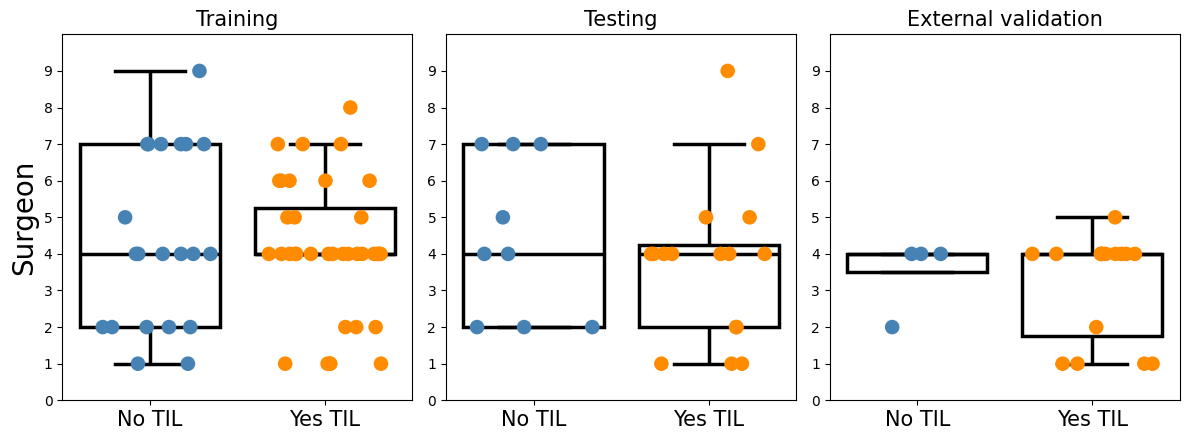

In [28]:
f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="Surgeon" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g0.set_yticks(range(10))
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="Surgeon",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.35, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('Surgeon', fontdict={'size': 20})
g0.set_ylim(0,10)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="Surgeon" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g1.set_yticks(range(10))
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="Surgeon",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.35, s=10.5)
g1.tick_params(axis='x', labelsize=15)
# g1.set_ylabel('Surgeon', fontdict={'size': 15})
g1.set_ylim(0,10)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="Surgeon" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g2.set_yticks(range(10))
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="Surgeon",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.35, s=10.5)
g2.tick_params(axis='x', labelsize=15)
# g2.set_ylabel('Surgeon', fontdict={'size': 15})
g2.set_ylim(0,10)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/surgeon_bxplot')

# plt.show()



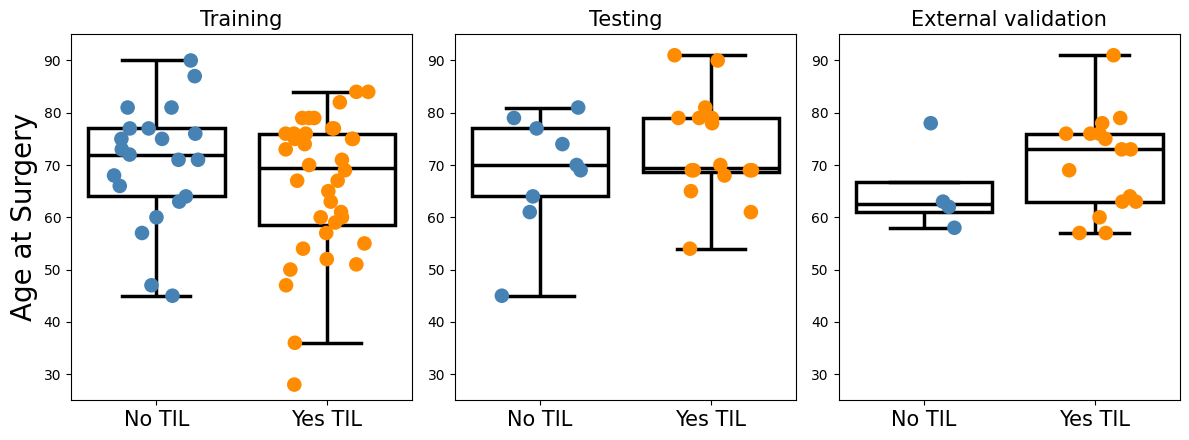

In [29]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="Age_at_Surgery" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="Age_at_Surgery",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('Age at Surgery', fontdict={'size': 20})
g0.set_ylim(25,95)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="Age_at_Surgery" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="Age_at_Surgery",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
g1.set_ylim(25,95)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="Age_at_Surgery" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="Age_at_Surgery",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15)
g2.set_ylim(25,95)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/Age_at_surgery_bxplot')

# plt.show()



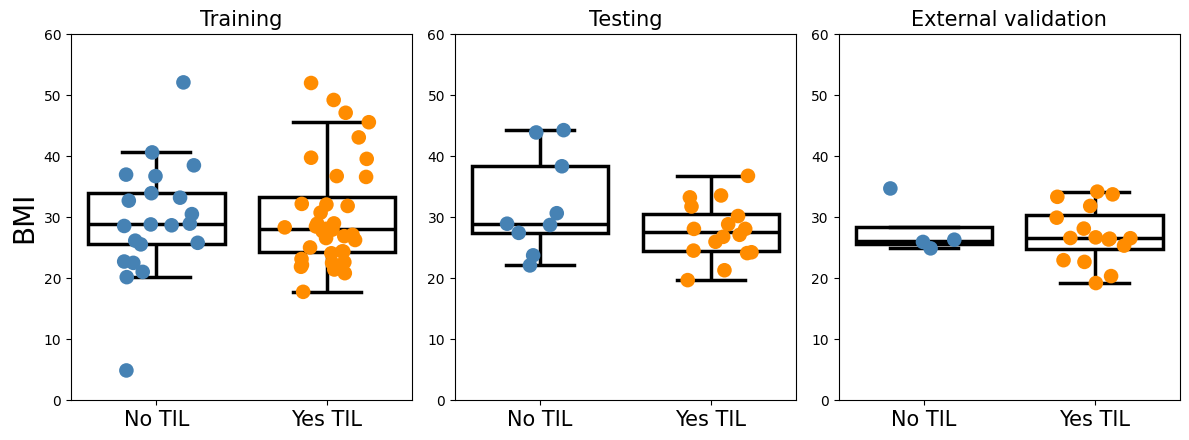

In [30]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="BMI" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="BMI",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('BMI', fontdict={'size': 20})
g0.set_ylim(0,60)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="BMI" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="BMI",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
g1.set_ylim(0,60)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="BMI" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="BMI",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15)
g2.set_ylim(0,60)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/bmi_bxplot')

# plt.show()



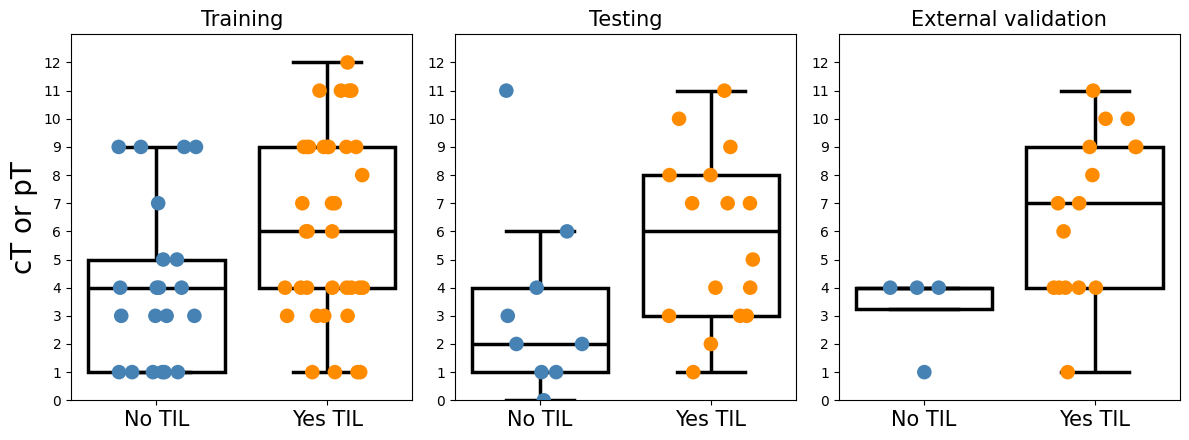

In [31]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="cT_or_pT" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g0.set_yticks(range(13))
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="cT_or_pT",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('cT or pT', fontdict={'size': 20})
g0.set_ylim(0,13)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="cT_or_pT" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g1.set_yticks(range(13))
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="cT_or_pT",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
g1.set_ylim(0,13)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="cT_or_pT" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
g2.set_yticks(range(13))
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="cT_or_pT",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15)
g2.set_ylim(0,13)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/ct_pt_bxplot')

# plt.show()



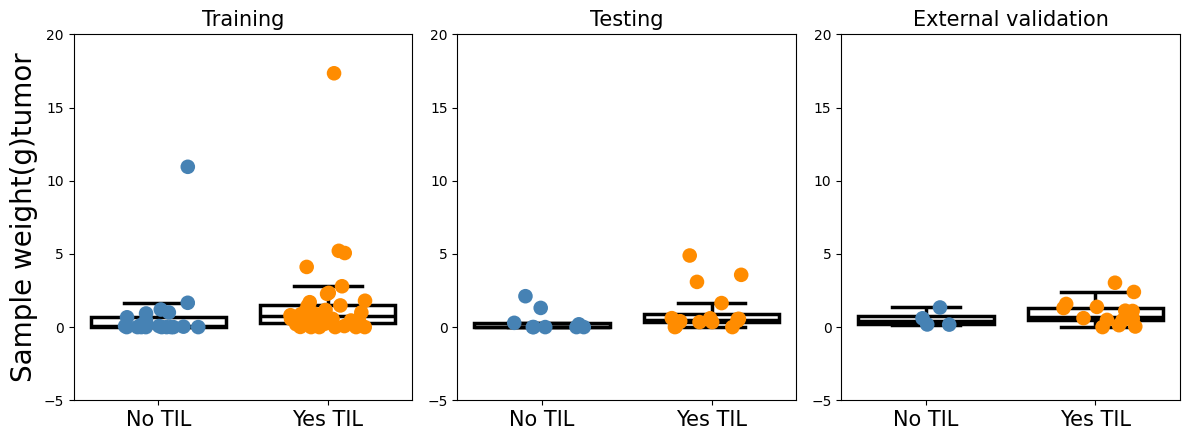

In [32]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="Sample_weight_g_tumor" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="Sample_weight_g_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15) 
g0.set_ylabel('Sample weight(g)tumor', fontdict={'size': 20})
g0.set_ylim(-5,20)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="Sample_weight_g_tumor" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="Sample_weight_g_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
g1.set_ylim(-5,20)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="Sample_weight_g_tumor" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="Sample_weight_g_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15) 
g2.set_ylim(-5,20)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/sampl_wt_bxplot')

# plt.show()



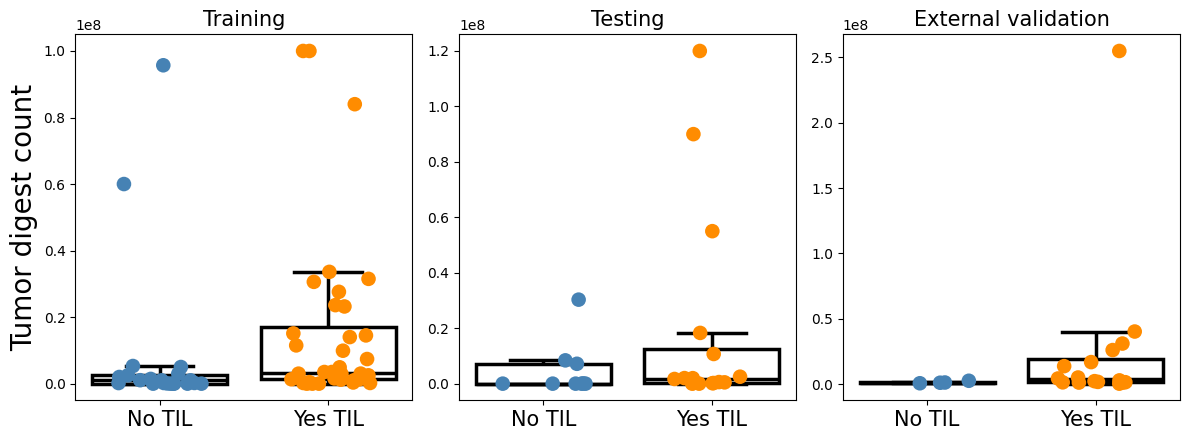

In [33]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="Tumor_digest_count_primary_tumor" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="Tumor_digest_count_primary_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('Tumor digest count', fontdict={'size': 20})
#g0.set_ylim(0,2.5*10**8)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="Tumor_digest_count_primary_tumor" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="Tumor_digest_count_primary_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
#g1.set_ylim(0,2.5*10**8)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="Tumor_digest_count_primary_tumor" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="Tumor_digest_count_primary_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15)
#g2.set_ylim(0,2.5*10**8)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/tumor_dg_ct_bxplot')

# plt.show()



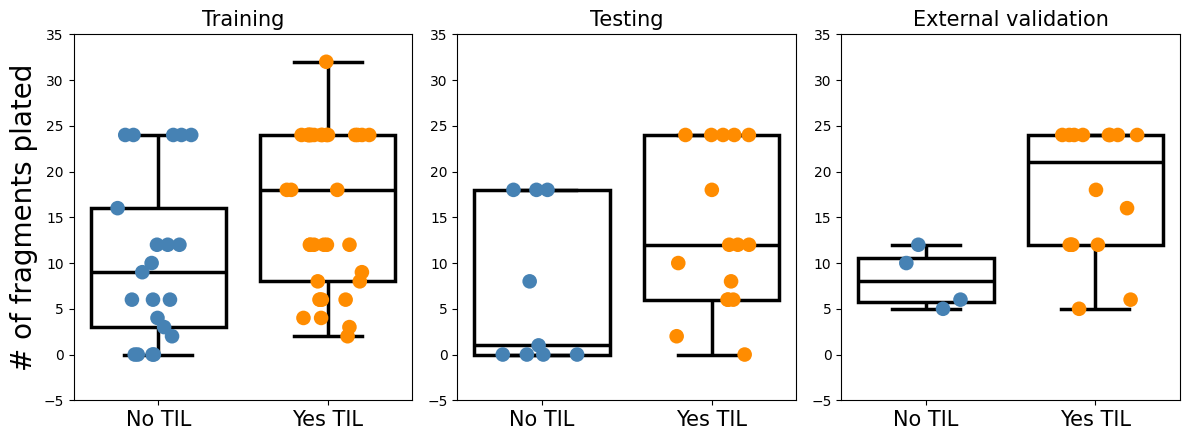

In [34]:


f, axes = plt.subplots(1, 3, figsize=(12, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

g0=sns.boxplot(x='OverallTILGrowth',y="Number_of_fragments_plated_tumor" ,data=bx_trn, ax=axes[0],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_trn, x="OverallTILGrowth", y="Number_of_fragments_plated_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[0],jitter=0.25, s=10.5)
g0.tick_params(axis='x', labelsize=15)
g0.set_ylabel('# of fragments plated', fontdict={'size': 20})
g0.set_ylim(-5,35)
g0.set(xlabel=None)
g0.set_title('Training', fontdict={'size': 15})

g1=sns.boxplot(x='OverallTILGrowth',y="Number_of_fragments_plated_tumor" ,data=bx_tst, ax=axes[1],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_tst, x="OverallTILGrowth", y="Number_of_fragments_plated_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[1],jitter=0.25, s=10.5)
g1.tick_params(axis='x', labelsize=15)
g1.set_ylim(-5,35)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set_title('Testing', fontdict={'size': 15})

g2=sns.boxplot(x='OverallTILGrowth',y="Number_of_fragments_plated_tumor" ,data=bx_ext, ax=axes[2],order=['No TIL','Yes TIL'],\
               showfliers=False, linewidth=2.5, **PROPS)
sns.stripplot(data=bx_ext, x="OverallTILGrowth", y="Number_of_fragments_plated_tumor",hue="OverallTILGrowth",order=['No TIL','Yes TIL'],\
              palette={"Yes TIL": "darkorange", "No TIL": "steelblue"}, legend=False, ax=axes[2],jitter=0.25, s=10.5)
g2.tick_params(axis='x', labelsize=15)
g2.set_ylim(-5,35)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_title('External validation', fontdict={'size': 15})

f.tight_layout()
savefig('./figs/frag_plate_bxplot')

# plt.show()



In [ ]:
print(